# Assignment 2: Image Classification with Residual Networks

The task in this section is to classify a type of clothing from images.

## Fashion-MNIST Dataset

We make use of the Fashion-MNIST dataset that contains gray-scale images of resolution $\mathbf X \in \mathbb R^{28\times28}$, classified into $O=10$ classes.

### Task (e): Training and Test Sets (3 Points)

Instantiate the training and the test sets of the `torchvision.datasets.FashionMNIST` dataset.
Make sure that the datasets are set to automatically download.
Make sure that the returned data is of type `torch.tensor` and with pixel values in range $[0,1]$.

Instantiate data loaders for the training and test set.
Select reasonable batch sizes.

In [5]:
import torch
import torchvision

# instantiate the training dataset
train_data = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

# instantiate the test dataset
test_data = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)
batch_size = 64

# instantiate data loaders for training and test sets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Visualization 1: Input Data

We sample three elements from the training dataset for each of the 10 classes, and visualized them in one plot.
This is only for displaying purposes, you do not need to run this cell.

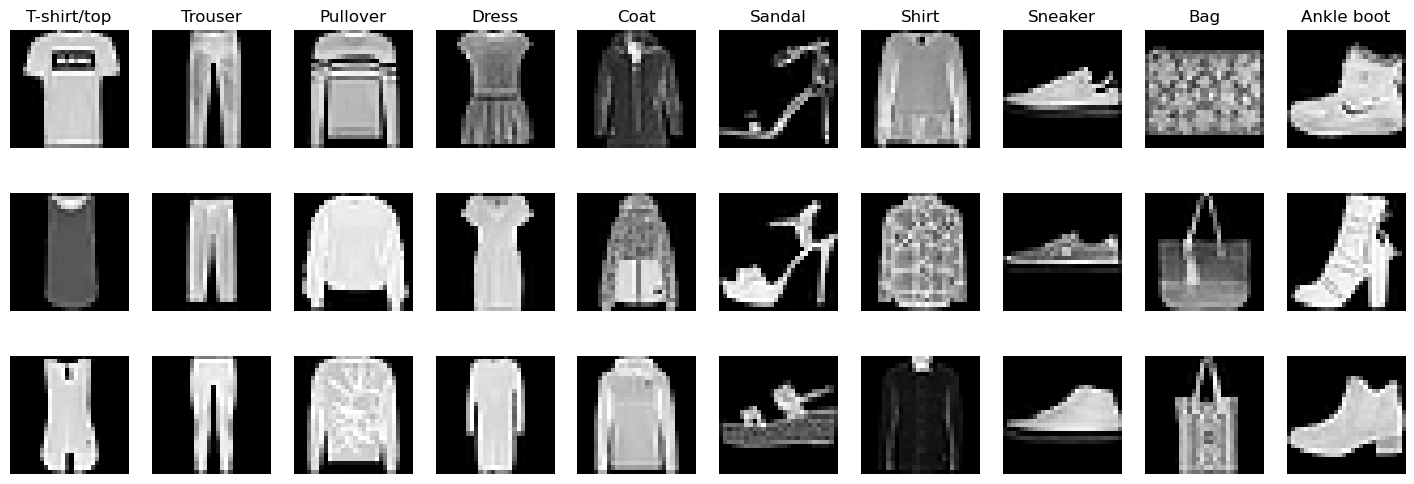

In [6]:
from matplotlib import pyplot
# create a grid with 3 rows and 10 columns
fig,axs = pyplot.subplots(3,10, figsize=(18,6))

# collect 3 samples for each of the 10 classes
indexes = [0]*10
for image, label in train_data:
    # check if we need more images for the current label
    if indexes[label] < 3:
        # get the according axis to plot into
        ax = axs[indexes[label],label]
        # plot the image
        ax.imshow(image[0], cmap="gray")
        ax.axis("off")
        # increase the counter for this class
        indexes[label] += 1
    # stop when sufficient samples have been processed
    if all(indexes[i] > 2 for i in range(10)):
           break
# make the plot more beautiful
legends = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
for i in range(10):
    axs[0,i].set_title(legends[i])


## Residual Block

For classifying this data, we want to make use of a convolutional network.
In order to improve training speed, we want to incorporate residual connections so that earlier layers are trained faster.
Our convolutions should have a kernel size of $3\times3$ pixels, and a residual block should enclose two convolution layers.

### Task (f): Residual Block Implementation (5 Points)

Implement the residual block that you have designed in (a) and (b) using PyTorch functionality.
You need to decide in which way the residual block should be implemented.
For parameters of your implementation that are not defined in this assignment, you need to decide how to set them.

In [7]:
# Implement the residual block
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


## Residual Network Design and Training

In our network, we want to stack three residual blocks, which are connected through an average pooling operation with size $2\times2$.
Finally, we want to have a single fully-connected layer that can be used to classify our $O=10$ classes.
A draft design of our network contains the following blocks:

1. Residual Block
2. Average Pooling
3. Residual Block
4. Average Pooling
5. Residual Block
6. Fully-connected Layer

Additionally, regularization plays a crucial role in training deep networks.
Implement at least one regularization technique into the training procedure.

### Task (g): Network Implementation (5 Points)

Implement and instantiate the convolutional network as defined above.
Make use of the residual blocks implemented in (e).
Again, you need to decide in which way this network is implemented, and whether additional layers need to be included into the final residual network.
For any parameter that are not defined in this assignment, you need to decide how to set them.

In [8]:
# possibly train on the GPU -- this is optional
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# implement residual network
network = nn.Sequential(
    ResidualBlock(1, 16),
    nn.AvgPool2d(2),
    ResidualBlock(16, 32),
    nn.AvgPool2d(2),
    ResidualBlock(32, 64),
    nn.Flatten(),
    nn.Linear(64*7*7, 10)
).to(device)

### Task (h): Network Training Loop (5 Points)

Instantiate a loss function that is appropriate for our task.
Instantiate an optimizer with useful parameters.
Run the training of the network on the training set for 10 epochs.
Report the classification accuracy on the test set after each epoch.

Note:

* The training of 10 epochs can take several minutes. There is no need to finish the training in order to pass this task.
* Reasonable test set accuracy values are above 80%.

In [9]:
# instantiate optimizer and loss
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

# train for 10 epochs
for epoch in range(10):
    # train for one epoch on the training set
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = network(images)
        loss_value = loss(outputs, labels)
        loss_value.backward()
        optimizer.step()
        

    # compute and report test set accuracy after each epoch
    accuracy = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = network(images)
        accuracy += (outputs.argmax(1) == labels).float().mean().item()
    

    print("Epoch", epoch, "test set accuracy", accuracy / len(test_loader))

Epoch 0 test set accuracy 0.8914211783439491
Epoch 1 test set accuracy 0.9149084394904459
Epoch 2 test set accuracy 0.9131170382165605
Epoch 3 test set accuracy 0.9212778662420382
Epoch 4 test set accuracy 0.9179936305732485
Epoch 5 test set accuracy 0.9233678343949044
Epoch 6 test set accuracy 0.9260549363057324
Epoch 7 test set accuracy 0.9277468152866242
Epoch 8 test set accuracy 0.9244625796178344
Epoch 9 test set accuracy 0.9194864649681529
